# MMP Analysis Functions

This notebook provides two main functions for Matched Molecular Pair (MMP) analysis:
1. `analyze_mmps()` - Generates MMP transforms from a dataset and displays them in an HTML table
2. `visualize_mmp_examples()` - Shows molecules containing a specific MMP transform

In [40]:
# Import required libraries
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import rdMolDraw2D
from operator import itemgetter
from itertools import combinations
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import io
import base64
from IPython.display import HTML
import mols2grid
import useful_rdkit_utils as uru

In [41]:
# Download scaffold_finder.py if not already present
import os
if not os.path.exists('scaffold_finder.py'):
    import requests
    lib_file = requests.get("https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/sar_analysis/scaffold_finder.py")
    with open("scaffold_finder.py", "w") as ofs:
        print(lib_file.text, file=ofs)
    print("Downloaded scaffold_finder.py")

from scaffold_finder import FragmentMol

In [42]:
# Helper functions

def remove_map_nums(mol):
    """Remove atom map numbers from a molecule"""
    for atm in mol.GetAtoms():
        atm.SetAtomMapNum(0)

def sort_fragments(mol):
    """
    Transform a molecule with multiple fragments into a list of molecules 
    that is sorted by number of atoms from largest to smallest
    """
    frag_list = list(Chem.GetMolFrags(mol, asMols=True))
    [remove_map_nums(x) for x in frag_list]
    frag_num_atoms_list = [(x.GetNumAtoms(), x) for x in frag_list]
    frag_num_atoms_list.sort(key=itemgetter(0), reverse=True)
    return [x[1] for x in frag_num_atoms_list]

def rxn_to_base64_image(rxn):
    """Convert an RDKit reaction to a base64 encoded image"""
    drawer = rdMolDraw2D.MolDraw2DCairo(300, 150)
    drawer.DrawReaction(rxn)
    drawer.FinishDrawing()
    text = drawer.GetDrawingText()
    im_text64 = base64.b64encode(text).decode('utf8')
    img_str = f"<img src='data:image/png;base64, {im_text64}'/>"
    return img_str

def stripplot_base64_image(dist, xlabel='Delta'):
    """
    Plot a distribution as a seaborn stripplot and save the 
    resulting image as a base64 image
    """
    plt.figure(dpi=150)
    sns.set(rc={'figure.figsize': (3, 1)})
    sns.set_style('whitegrid')
    ax = sns.stripplot(x=dist)
    ax.axvline(0, ls="--", c="red")
    ax.set_xlim(-5, 5)
    ax.set_xlabel(xlabel, fontsize=10)
    s = io.BytesIO()
    plt.savefig(s, format='png', bbox_inches="tight")
    plt.close()
    s = base64.b64encode(s.getvalue()).decode("utf-8").replace("\n", "")
    return '<img align="left" src="data:image/png;base64,%s">' % s

## Main Function 1: Analyze MMPs

This function takes a CSV file with molecular data and generates an HTML table of MMP transforms.

In [43]:
def analyze_mmps(csv_path, 
                 smiles_col='SMILES', 
                 id_col='ID', 
                 activity_col='pIC50',
                 min_transform_occurrence=3,
                 max_cuts=1,
                 rows_to_show=10,
                 ascending=True,
                 remove_salts=True):
    """
    Analyze Matched Molecular Pairs (MMPs) from a CSV file and display results as HTML table.
    
    Parameters:
    -----------
    csv_path : str
        Path to CSV file containing molecular data
    smiles_col : str
        Name of the SMILES column (default: 'SMILES')
    id_col : str
        Name of the ID column (default: 'ID')
    activity_col : str
        Name of the activity column (default: 'pIC50')
    min_transform_occurrence : int
        Minimum number of times a transform must occur to be included (default: 5)
    max_cuts : int
        Maximum number of cuts for fragmentation (default: 1)
    rows_to_show : int
        Number of rows to display in the HTML table (default: 10)
    ascending : bool
        Sort order for mean_delta (True = lowest first, False = highest first)
    remove_salts : bool
        Whether to remove salts and keep largest fragment (default: True)
    
    Returns:
    --------
    tuple : (mmp_df, delta_df, HTML_table)
        - mmp_df: DataFrame with MMP transforms and statistics
        - delta_df: DataFrame with all molecule pairs
        - HTML_table: IPython.display.HTML object for display
    """
    
    print("Loading data...")
    df = pd.read_csv(csv_path)
    print(f"Loaded {len(df)} molecules")
    
    # Add RDKit molecule column
    df['mol'] = df[smiles_col].apply(Chem.MolFromSmiles)
    
    # Remove salts if requested
    if remove_salts:
        print("Removing salts...")
        df['mol'] = df['mol'].apply(uru.get_largest_fragment)
    
    # Decompose molecules to get scaffolds and side chains
    print("Fragmenting molecules...")
    row_list = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Fragmenting"):
        smiles = row[smiles_col]
        name = row[id_col]
        activity = row[activity_col]
        mol = row['mol']
        
        frag_list = FragmentMol(mol, maxCuts=max_cuts)
        for _, frag_mol in frag_list:
            pair_list = sort_fragments(frag_mol)
            tmp_list = [smiles] + [Chem.MolToSmiles(x) for x in pair_list] + [name, activity]
            row_list.append(tmp_list)
    
    row_df = pd.DataFrame(row_list, columns=["SMILES", "Core", "R_group", "Name", activity_col])
    print(f"Generated {len(row_df)} fragment pairs")
    
    # Collect pairs with the same scaffold
    print("Finding matched pairs...")
    delta_list = []
    for k, v in tqdm(row_df.groupby("Core"), desc="Pairing"):
        if len(v) > 2:
            for a, b in combinations(range(0, len(v)), 2):
                reagent_a = v.iloc[a]
                reagent_b = v.iloc[b]
                if reagent_a.SMILES == reagent_b.SMILES:
                    continue
                reagent_a, reagent_b = sorted([reagent_a, reagent_b], key=lambda x: x.SMILES)
                delta = reagent_b[activity_col] - reagent_a[activity_col]
                delta_list.append(
                    list(reagent_a.values) + list(reagent_b.values) +
                    [f"{reagent_a.R_group.replace('*','*-')}>>{reagent_b.R_group.replace('*','*-')}", delta]
                )
    
    # Create delta dataframe
    cols = ["SMILES_1", "Core_1", "R_group_1", "Name_1", f"{activity_col}_1",
            "SMILES_2", "Core_2", "R_group_2", "Name_2", f"{activity_col}_2",
            "Transform", "Delta"]
    delta_df = pd.DataFrame(delta_list, columns=cols)
    print(f"Found {len(delta_df)} molecule pairs")
    
    # Collect frequently occurring pairs
    print(f"Filtering transforms (min occurrence: {min_transform_occurrence})...")
    mmp_list = []
    for k, v in delta_df.groupby("Transform"):
        if len(v) >= min_transform_occurrence:
            mmp_list.append([k, len(v), v.Delta.values])
    
    mmp_df = pd.DataFrame(mmp_list, columns=["Transform", "Count", "Deltas"])
    print(f"Found {len(mmp_df)} frequent transforms")
    
    if len(mmp_df) == 0:
        print("No transforms found with the specified minimum occurrence.")
        print("Try reducing min_transform_occurrence parameter.")
        return None, delta_df, None
    
    mmp_df['idx'] = range(0, len(mmp_df))
    mmp_df['mean_delta'] = [x.mean() for x in mmp_df.Deltas]
    mmp_df['rxn_mol'] = mmp_df.Transform.apply(AllChem.ReactionFromSmarts, useSmiles=True)
    
    # Create index linking delta_df and mmp_df
    transform_dict = dict([(a, b) for a, b in mmp_df[["Transform", "idx"]].values])
    delta_df['idx'] = [transform_dict.get(x) for x in delta_df.Transform]
    
    # Generate images for HTML table
    print("Generating visualizations...")
    tqdm.pandas(desc="MMP transforms")
    mmp_df['MMP Transform'] = mmp_df.rxn_mol.progress_apply(rxn_to_base64_image)
    tqdm.pandas(desc="Delta distributions")
    mmp_df['Delta Distribution'] = mmp_df.Deltas.progress_apply(
        lambda x: stripplot_base64_image(x, xlabel=f'Δ {activity_col}')
    )
    
    # Sort by mean_delta and reset index to show it in table
    mmp_df.sort_values("mean_delta", inplace=True, ascending=ascending)
    mmp_df_display = mmp_df.reset_index(drop=True)
    
    # Create HTML table with idx column visible
    html_table = mmp_df_display[['idx', 'MMP Transform', 'Count', "mean_delta", "Delta Distribution"]].round(2).head(rows_to_show).to_html(escape=False, index=False)
    
    print("\nAnalysis complete!")
    print(f"Showing top {rows_to_show} transforms sorted by mean_delta (ascending={ascending})")
    print("Use the idx value from the table to query specific transforms with visualize_mmp_examples()")
    
    # Return HTML object for display
    return mmp_df, delta_df, HTML(html_table)

## Main Function 2: Visualize MMP Examples

This function displays all molecules containing a specific MMP transform.

In [44]:
def visualize_mmp_examples(delta_df, 
                          query_idx, 
                          activity_col='pIC50',
                          n_cols=4, 
                          img_size=(200, 200)):
    """
    Visualize molecules that include a particular MMP transform.
    
    Parameters:
    -----------
    delta_df : pd.DataFrame
        DataFrame containing all molecule pairs (returned from analyze_mmps)
    query_idx : int
        Index of the MMP transform to visualize (from the idx column in mmp_df)
    activity_col : str
        Name of the activity column (default: 'pIC50')
    n_cols : int
        Number of columns in the grid display (default: 4)
    img_size : tuple
        Size of each molecule image (default: (200, 200))
    
    Returns:
    --------
    pd.DataFrame : DataFrame with examples for display
    """
    
    # Check if idx column exists
    if 'idx' not in delta_df.columns:
        print("Error: 'idx' column not found in delta_df.")
        print("Make sure you've run analyze_mmps() first and it found transforms.")
        return None
    
    example_list = []
    query_data = delta_df.query("idx == @query_idx").sort_values("Delta", ascending=False)
    
    if len(query_data) == 0:
        print(f"No data found for query_idx = {query_idx}")
        print(f"Available idx values: {sorted(delta_df['idx'].dropna().unique().astype(int).tolist())}")
        return None
    
    print(f"Found {len(query_data)} pairs for transform idx={query_idx}")
    
    for idx, row in query_data.iterrows():
        smi_1, name_1, activity_1 = row.SMILES_1, row.Name_1, row[f"{activity_col}_1"]
        smi_2, name_2, activity_2 = row.SMILES_2, row.Name_2, row[f"{activity_col}_2"]
        tmp_list = [(smi_1, name_1, activity_1), (smi_2, name_2, activity_2)]
        tmp_list.sort(key=itemgetter(0))
        example_list.append(tmp_list[0])
        example_list.append(tmp_list[1])
    
    example_df = pd.DataFrame(example_list, columns=["SMILES", "Name", activity_col])
    
    # Display using mols2grid
    return mols2grid.display(
        example_df,
        n_cols=n_cols,
        template='static',
        prerender=True,
        size=img_size,
        subset=["img", activity_col, "Name"],
        transform={activity_col: lambda x: f"{x:.2f}"}
    )

## Example Usage

Below are examples of how to use the functions.

Loading data...
Loaded 11 molecules
Removing salts...
Fragmenting molecules...


Fragmenting:   0%|          | 0/11 [00:00<?, ?it/s]

Generated 59 fragment pairs
Finding matched pairs...


Pairing:   0%|          | 0/47 [00:00<?, ?it/s]

Found 22 molecule pairs
Filtering transforms (min occurrence: 1)...
Found 22 frequent transforms
Generating visualizations...


MMP transforms:   0%|          | 0/22 [00:00<?, ?it/s]

Delta distributions:   0%|          | 0/22 [00:00<?, ?it/s]


Analysis complete!
Showing top 20 transforms sorted by mean_delta (ascending=True)
Use the idx value from the table to query specific transforms with visualize_mmp_examples()



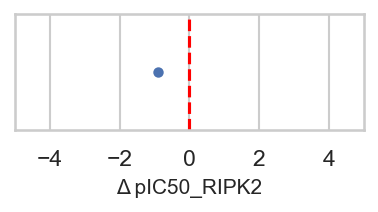
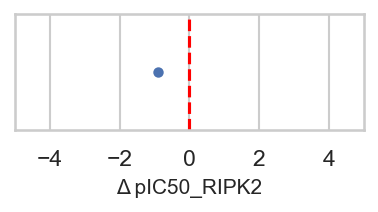
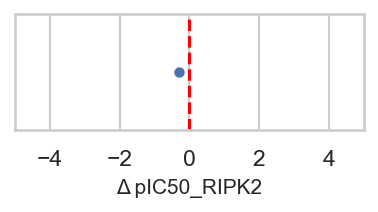
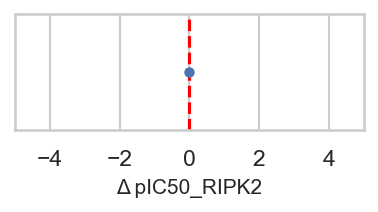
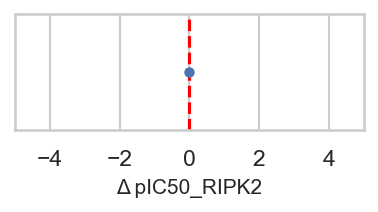
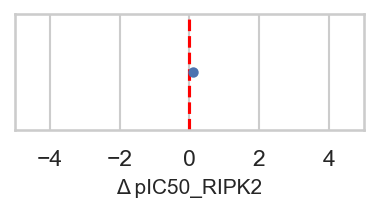
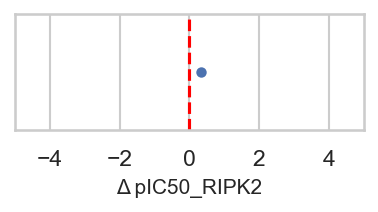
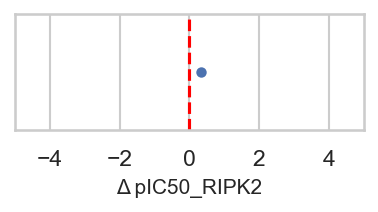
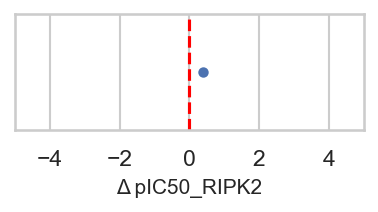
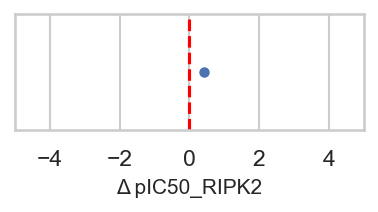
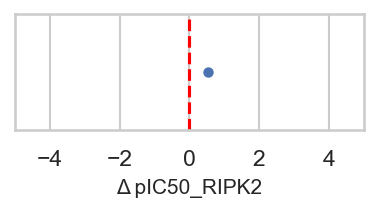
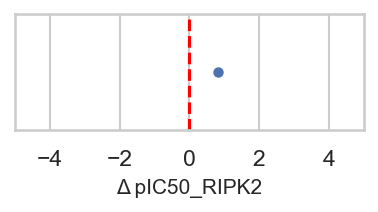
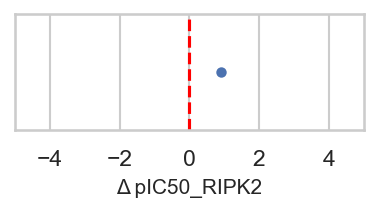
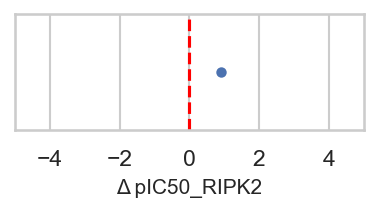
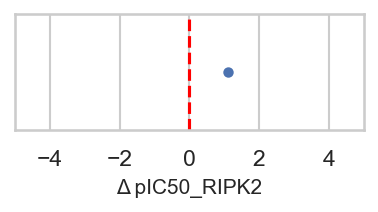
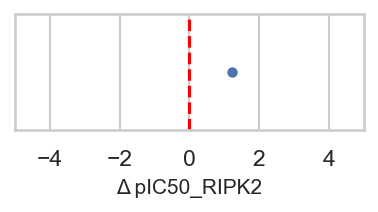
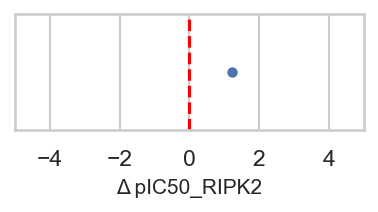
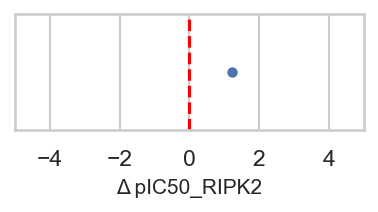
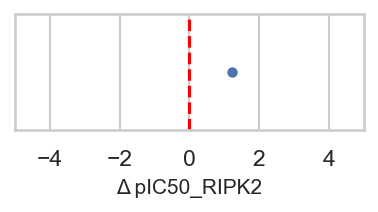
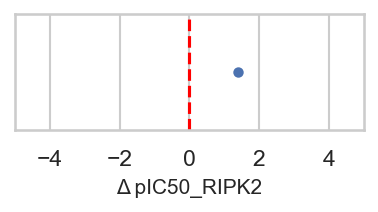

In [45]:
# Example 1: Analyze MMPs from RIPK2 ligands
mmp_df, delta_df, html_table = analyze_mmps(
    csv_path='RIPK2_ligands_mol12removed.csv',
    smiles_col='SMILES',
    id_col='ID',
    activity_col='pIC50_RIPK2',  # Note: you might want to convert to pIC50 first
    min_transform_occurrence=1,  # Lower threshold for smaller datasets
    max_cuts=1,
    rows_to_show=20,
    ascending=True,  # True = show transforms that decrease activity first
    remove_salts=True
)

# Display the HTML table
html_table

In [46]:
# Example 2: Visualize molecules for a specific transform
# Change query_idx to the idx value from the table above (far left column)
query_idx = 2  # Change this to explore different transforms

visualize_mmp_examples(
    delta_df=delta_df,
    query_idx=query_idx,
    activity_col='pIC50_RIPK2',
    n_cols=4,
    img_size=(200, 200)
)

Found 1 pairs for transform idx=2


MolGridWidget()

Loading data...
Loaded 4042 molecules
Removing salts...
Fragmenting molecules...
Loaded 4042 molecules
Removing salts...
Fragmenting molecules...


Fragmenting:   0%|          | 0/4042 [00:00<?, ?it/s]

Generated 31039 fragment pairs
Finding matched pairs...


Pairing:   0%|          | 0/23588 [00:00<?, ?it/s]

Found 30200 molecule pairs
Filtering transforms (min occurrence: 5)...
Found 147 frequent transforms
Generating visualizations...


MMP transforms:   0%|          | 0/147 [00:00<?, ?it/s]

Delta distributions:   0%|          | 0/147 [00:00<?, ?it/s]


Analysis complete!
Showing top 15 transforms sorted by mean_delta (ascending=False)
Use the idx value from the table to query specific transforms with visualize_mmp_examples()



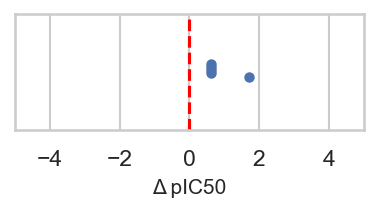
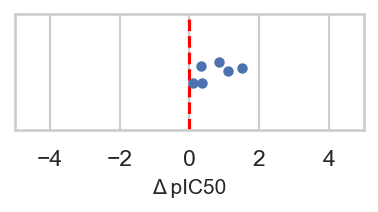
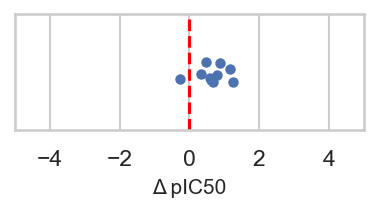
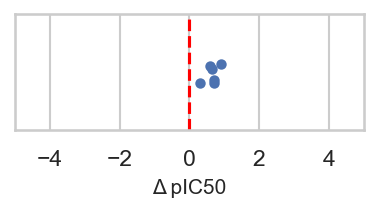
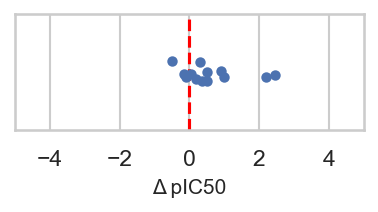
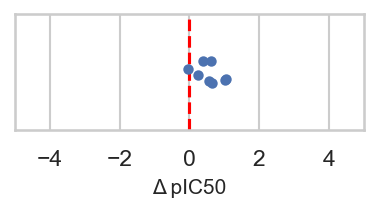
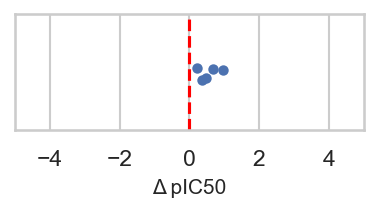
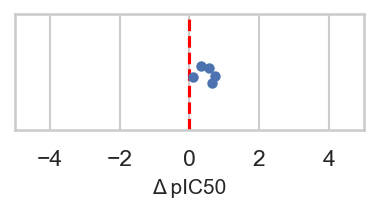
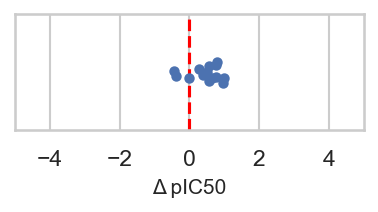
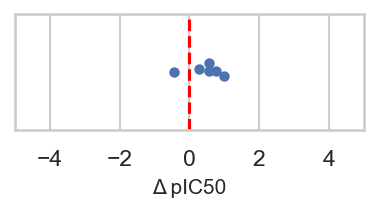
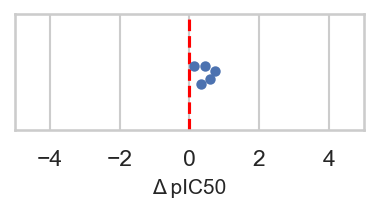
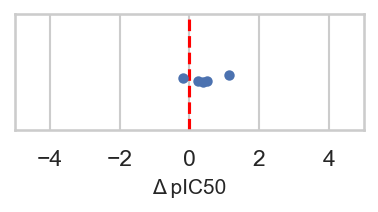
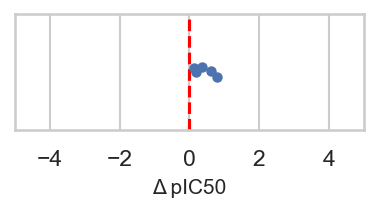
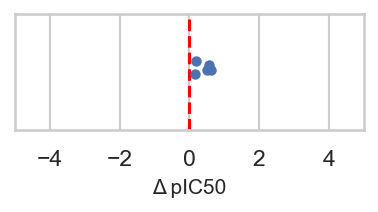
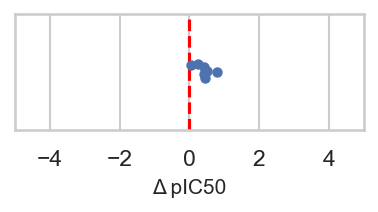

In [47]:
# Example 3: Using with a different dataset (hERG data from URL)
mmp_df_herg, delta_df_herg, html_table_herg = analyze_mmps(
    csv_path='https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/data/hERG.csv',
    smiles_col='SMILES',
    id_col='Name',
    activity_col='pIC50',
    min_transform_occurrence=5,
    max_cuts=1,
    rows_to_show=15,
    ascending=False,  # False = show transforms that increase activity first
    remove_salts=True
)

html_table_herg

In [48]:
# Explore specific transform from hERG data
visualize_mmp_examples(
    delta_df=delta_df_herg,
    query_idx=1,  # Change based on the table above
    activity_col='pIC50',
    n_cols=4,
    img_size=(250, 250)
)

Found 9 pairs for transform idx=1


MolGridWidget()

## Additional Analysis

You can also access the dataframes directly for custom analysis.

In [49]:
# View the top transforms sorted by different criteria
if mmp_df is not None:
    print("Top 10 transforms by count:")
    display(mmp_df.sort_values('Count', ascending=False)[['Transform', 'Count', 'mean_delta']].head(10))

Top 10 transforms by count:


,Transform,Count,mean_delta
7,*-Nc1ccc2scnc2c1>>*-Nc1n[nH]c2ccc(F)cc12,1,-0.89963
17,*-c1ccc2scnc2c1>>*-c1n[nH]c2ccc(F)cc12,1,-0.89963
10,*-OC>>*-C(F)(F)F,1,1.49485
12,*-OC>>*-c1cccnc1,1,1.39794
13,*-c1ccc2[nH]nnc2c1>>*-c1cc(O)ccc1C,1,1.22185
3,*-Nc1ccc2[nH]nnc2c1>>*-Nc1cc(O)ccc1C,1,1.22185
8,*-Nc1n[nH]c2ccc(F)cc12>>*-Nc1cc(O)ccc1C,1,1.22185
21,*-c1n[nH]c2ccc(F)cc12>>*-c1cc(O)ccc1C,1,1.22185
9,*-OC>>*-C(=O)NCC1CCOCC1,1,1.09691
14,*-c1ccc2[nH]nnc2c1>>*-c1ccc2scnc2c1,1,0.89963


In [50]:
# Get statistics on delta distributions
if mmp_df is not None:
    mmp_df['std_delta'] = [x.std() for x in mmp_df.Deltas]
    mmp_df['median_delta'] = [np.median(x) for x in mmp_df.Deltas]
    display(mmp_df[['Transform', 'Count', 'mean_delta', 'median_delta', 'std_delta']].head(10))

,Transform,Count,mean_delta,median_delta,std_delta
7,*-Nc1ccc2scnc2c1>>*-Nc1n[nH]c2ccc(F)cc12,1,-0.89963,-0.89963,0.0
17,*-c1ccc2scnc2c1>>*-c1n[nH]c2ccc(F)cc12,1,-0.89963,-0.89963,0.0
18,*-c1cccnc1>>*-C(=O)NCC1CCOCC1,1,-0.30103,-0.30103,0.0
5,*-Nc1ccc2[nH]nnc2c1>>*-Nc1n[nH]c2ccc(F)cc12,1,0.00000,0.00000,0.0
15,*-c1ccc2[nH]nnc2c1>>*-c1n[nH]c2ccc(F)cc12,1,0.00000,0.00000,0.0
19,*-c1cccnc1>>*-C(F)(F)F,1,0.09691,0.09691,0.0
6,*-Nc1ccc2scnc2c1>>*-Nc1cc(O)ccc1C,1,0.32222,0.32222,0.0
16,*-c1ccc2scnc2c1>>*-c1cc(O)ccc1C,1,0.32222,0.32222,0.0
0,*-C(=O)NCC1CCOCC1>>*-C(F)(F)F,1,0.39794,0.39794,0.0
2,*-C(F)(F)F>>*-S(C)(=O)=O,1,0.42597,0.42597,0.0
